# Notebook for social neural population decoding (NPD)
With inspiration from:
"The geometry of hippocampal CA2 representations enables abstract coding of social familiarity and identity" - Boyle 2022

**Note!** The analysis needs to be repeated for *each animal separately*, and only persistent units across all selected actions will be included in the analysis. This because the input to an SVM is interpreted as a vector of unique units. Hence units from an animal B can not replace the input of an SVM trained on units from animal A. Lastly, this notebook trains SVMs to predict social interactions. Other notebooks try to decode trial and space.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('../bioAI.mplstyle')
import expipe
import sys
import pathlib
import numpy as np
import numpy.ma as ma
import scipy
import tqdm
import pandas as pd

from scipy.interpolate import interp1d

sys.path.append('../ca2-mec') if '../ca2-mec' not in sys.path else None 
import dataloader as dl
from utils import *

In [3]:
project = expipe.get_project(dl.project_path())
project.actions

In [4]:
lim = [0,1200] # limit recording times - in seconds
include_actions = ['011-120321-2', '011-120321-3', '011-120321-4', '011-120321-5', '011-120321-6'] # choose actions to include
#include_actions = ['022-160322-1', '022-160322-2', '022-160322-3', '022-160322-4', '022-160322-5', '022-160322-7']

# Cast assertion error if include_actions contain actions from multiple entities. 
animal_entity = include_actions[0].split('-')[0]
multiple_entities = all([animal_entity in action_id for action_id in include_actions])
assert multiple_entities, "Requires only actions from same animal entity! Read start of notebook!"

spikes = []
tracking = {}
for action_id in include_actions:
    spikes += dl.load_spiketrains(action_id, lim=lim, identify_neurons=True)
    tracking[action_id] = dl.load_tracking(action_id, lim=lim, ca2_transform_data=True) # only get positions
    
print("load #spikes: ", len(spikes))
    
# correct for inconsistent mua-annotations
spikes = dl.correct_mua(spikes, only_good_mua=True)
print("#units after mua-corrections:", len(spikes))
spatial_map = sp.SpatialMap()

# SELECT brain region(s) to include cells from
spikes = dl.in_brain_regions(spikes, ['ca2'])
print("#units after brain region selection:", len(spikes))

# only include cells that are persistent across all actions
spikes = dl.persistent_units(spikes, include_actions)
print(f"Num spike_trains: {len(spikes)}. Num persistent units: {len(spikes) / len(include_actions)}")

load #spikes:  124
#units after mua-corrections: 121
#units after brain region selection: 121
Num spike_trains: 70. Num persistent units: 14.0


### Setup input data and labels
This should follow the format:
- X.shape = (samples, num_features) -> neural rate activity
- y.shape = (samples) -> scalars indicating labelled class

In [5]:
# sort spikes on unit_idnum and action_id, respectively
spikes.sort(key=lambda spike_train: spike_train.annotations['unit_idnum'])
spikes.sort(key=lambda spike_train: spike_train.annotations['action_id'])

# print the spike properties that the spikes list has been sorted on to confirm sorting
[(spike_train.annotations["action_id"], spike_train.annotations["unit_idnum"]) for spike_train in spikes]

[('011-120321-2', 0),
 ('011-120321-2', 1),
 ('011-120321-2', 4),
 ('011-120321-2', 5),
 ('011-120321-2', 6),
 ('011-120321-2', 9),
 ('011-120321-2', 20),
 ('011-120321-2', 21),
 ('011-120321-2', 22),
 ('011-120321-2', 23),
 ('011-120321-2', 24),
 ('011-120321-2', 25),
 ('011-120321-2', 28),
 ('011-120321-2', 29),
 ('011-120321-3', 0),
 ('011-120321-3', 1),
 ('011-120321-3', 4),
 ('011-120321-3', 5),
 ('011-120321-3', 6),
 ('011-120321-3', 9),
 ('011-120321-3', 20),
 ('011-120321-3', 21),
 ('011-120321-3', 22),
 ('011-120321-3', 23),
 ('011-120321-3', 24),
 ('011-120321-3', 25),
 ('011-120321-3', 28),
 ('011-120321-3', 29),
 ('011-120321-4', 0),
 ('011-120321-4', 1),
 ('011-120321-4', 4),
 ('011-120321-4', 5),
 ('011-120321-4', 6),
 ('011-120321-4', 9),
 ('011-120321-4', 20),
 ('011-120321-4', 21),
 ('011-120321-4', 22),
 ('011-120321-4', 23),
 ('011-120321-4', 24),
 ('011-120321-4', 25),
 ('011-120321-4', 28),
 ('011-120321-4', 29),
 ('011-120321-5', 0),
 ('011-120321-5', 1),
 ('011-1

In [17]:
window_size = 0.1 # in seconds
res = 10 # spatial/social resolution
input_dim = int(len(spikes)/len(include_actions)) # number of persistent units
X = []
y_true = []

for action_id in tracking:
    labels = social_label(action_id)
    x,y,t,_ = tracking[action_id].T
    cms = corner_masks(x,y)
    f_labels = interp1d(t, cms.T, kind='nearest', fill_value='extrapolate')
    
    trial_duration = t[-1] - t[0]
    num_samples = int(trial_duration / window_size) - 1
    X_tmp = np.zeros((input_dim, num_samples))
    y_tmp = np.zeros((num_samples))
    include_mask = np.ones(num_samples,dtype=bool) # to remove indices where rat in middle of box
    
    for i in tqdm.trange(num_samples):
        time_window = (i*window_size, (i+1)*window_size)
        # interpolate and round social-label for current time window
        rat_pos = f_labels(np.linspace(*time_window, res))
        idx = np.argmax(np.sum(rat_pos,axis=-1))
        if idx == 4:
            # rat in middle of box / not socializing
            include_mask[i] = False
            continue
        y_tmp[i] = labels[idx]
        
        # loop units for current action_id
        action_spikes = [spike_train for spike_train in spikes if spike_train.annotations["action_id"] == action_id]
        for j, spike_train in enumerate(action_spikes):
            X_tmp[j,i] = np.sum((time_window[0] <= spike_train) & (spike_train <= time_window[1]))
        
    X.append(X_tmp[:,include_mask])
    y_true.append(y_tmp[include_mask])

X = np.concatenate(X,axis=1).T
y_true = np.concatenate(y_true).T
print(X.shape, y_true.shape)

100%|██████████| 11998/11998 [00:02<00:00, 5468.04it/s]

(38550, 14) (38550,)


In [18]:
# choose categories to include in analysis
if False: # ---> SET TO 'True' <--- if want to use
    f_vs_n_mask = np.logical_or(y_true == 1, y_true == 2)
    y_true = y_true[f_vs_n_mask]
    X = X[f_vs_n_mask]
    print(X.shape, y_true.shape)

In [19]:
# show the range of rates an input can take, and how often these appear.
# first row: number of spikes within time window
# second row: number of occurences a unit has this many spikes
np.unique(X, return_counts=True)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 19., 20.]),
 array([474123,  28350,  16992,  10317,   5335,   2410,   1048,    520,
           285,    162,     73,     41,     20,     10,      4,      4,
             3,      1,      1,      1]))

## MACHINE LEARNING

In [9]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.2, random_state=0)

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [10]:
categories, counts = np.unique(y_true, return_counts=True)
print(f"Categories: {categories}.", "Probability of category:", counts/np.sum(counts))

print("\n SVM score: ", clf.score(X_test,y_test))

Categories: [-1.  0.  1.  2.]. Probability of category: [0.45745785 0.17071336 0.30386511 0.06796368]

 SVM score:  0.5619974059662776


### Plot ratemaps of units involved in SVM-analysis

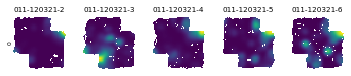

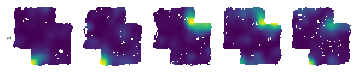

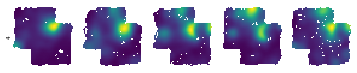

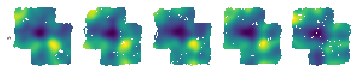

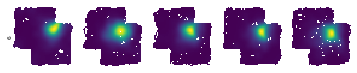

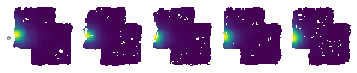

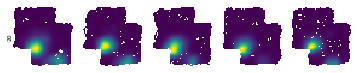

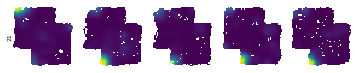

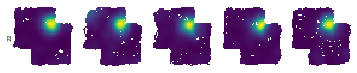

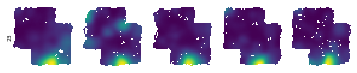

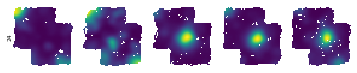

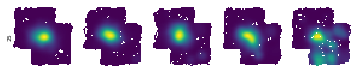

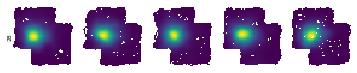

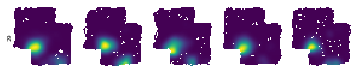

In [11]:
# sort on unit id
spikes.sort(key=lambda spike_train: spike_train.annotations['unit_idnum'])
unique_unit_idnums = np.unique([spike_train.annotations["unit_idnum"] for spike_train in spikes])
include_actions.sort()
figscale = 1
from plotting_functions import axis_off_labels_on

add_title = True
spatial_map = sp.SpatialMap()
for unit_idnum in unique_unit_idnums:
    unit_spikes = [spike_train for spike_train in spikes if spike_train.annotations["unit_idnum"] == unit_idnum]
    fig,axs = plt.subplots(ncols=len(unit_spikes),figsize=(len(unit_spikes)*figscale, 1*figscale))
    
    for ax, spike_train in zip(axs, unit_spikes):
        x,y,t,_ = tracking[spike_train.annotations["action_id"]].T
        ratemap = spatial_map.rate_map(x, y, t, spike_train)
        ax.imshow(ratemap.T,origin='lower')
        axis_off_labels_on(ax)
        
        # add action_id title to first few plots
        if add_title:
            ax.set_title(spike_train.annotations["action_id"])
    add_title = False
    
    axs[0].set_ylabel(spike_train.annotations["unit_idnum"])